首先将Sharegpt格式的数据集train_data_law.json转换为Alpaca格式train_data_law_alpaca_dataset.json。

如果不做这个转换的话，加载数据时总是出错。

In [1]:
# 将sharegpt格式的数据集/home/haoyu/work/code/DiveIntoFineTuning/Qwen/data/train_data_law.json转换为alpaca格式。
# 转换脚本如下： transform_sharegpt_to_alpaca.py

"""
import json

def sharegpt_to_alpaca(sharegpt_data):
    alpaca_data = []
    
    for sample in sharegpt_data:
        conversations = sample.get("conversations", [])
        
        # 确保对话至少包含一轮 user 和 assistant
        if len(conversations) >= 2 and conversations[0]["from"] == "user" and conversations[1]["from"] == "assistant":
            instruction = conversations[0]["value"].strip()
            output = conversations[1]["value"].strip()
            
            # 构建 Alpaca 格式的样本
            alpaca_sample = {
                "instruction": instruction,
                "input": "",  # 如果有上下文信息，可以填充到这里
                "output": output
            }
            alpaca_data.append(alpaca_sample)
    
    return alpaca_data

# 示例：读取 ShareGPT 数据并转换为 Alpaca 格式
if __name__ == "__main__":
    # 读取 ShareGPT 格式的数据
    with open("train_data_law.json", "r", encoding="utf-8") as f:
        sharegpt_data = json.load(f)
    
    # 转换为 Alpaca 格式
    alpaca_data = sharegpt_to_alpaca(sharegpt_data)
    
    # 保存为 Alpaca 格式的数据
    with open("train_data_law_alpaca_dataset.json", "w", encoding="utf-8") as f:
        json.dump(alpaca_data, f, ensure_ascii=False, indent=2)
    
    print(f"Converted {len(alpaca_data)} samples to Alpaca format.")
"""

'\nimport json\n\ndef sharegpt_to_alpaca(sharegpt_data):\n    alpaca_data = []\n    \n    for sample in sharegpt_data:\n        conversations = sample.get("conversations", [])\n        \n        # 确保对话至少包含一轮 user 和 assistant\n        if len(conversations) >= 2 and conversations[0]["from"] == "user" and conversations[1]["from"] == "assistant":\n            instruction = conversations[0]["value"].strip()\n            output = conversations[1]["value"].strip()\n            \n            # 构建 Alpaca 格式的样本\n            alpaca_sample = {\n                "instruction": instruction,\n                "input": "",  # 如果有上下文信息，可以填充到这里\n                "output": output\n            }\n            alpaca_data.append(alpaca_sample)\n    \n    return alpaca_data\n\n# 示例：读取 ShareGPT 数据并转换为 Alpaca 格式\nif __name__ == "__main__":\n    # 读取 ShareGPT 格式的数据\n    with open("train_data_law.json", "r", encoding="utf-8") as f:\n        sharegpt_data = json.load(f)\n    \n    # 转换为 Alpaca 格式\n    alpaca_data = 

Sharegpt格式的train_data_law.json内容如下：

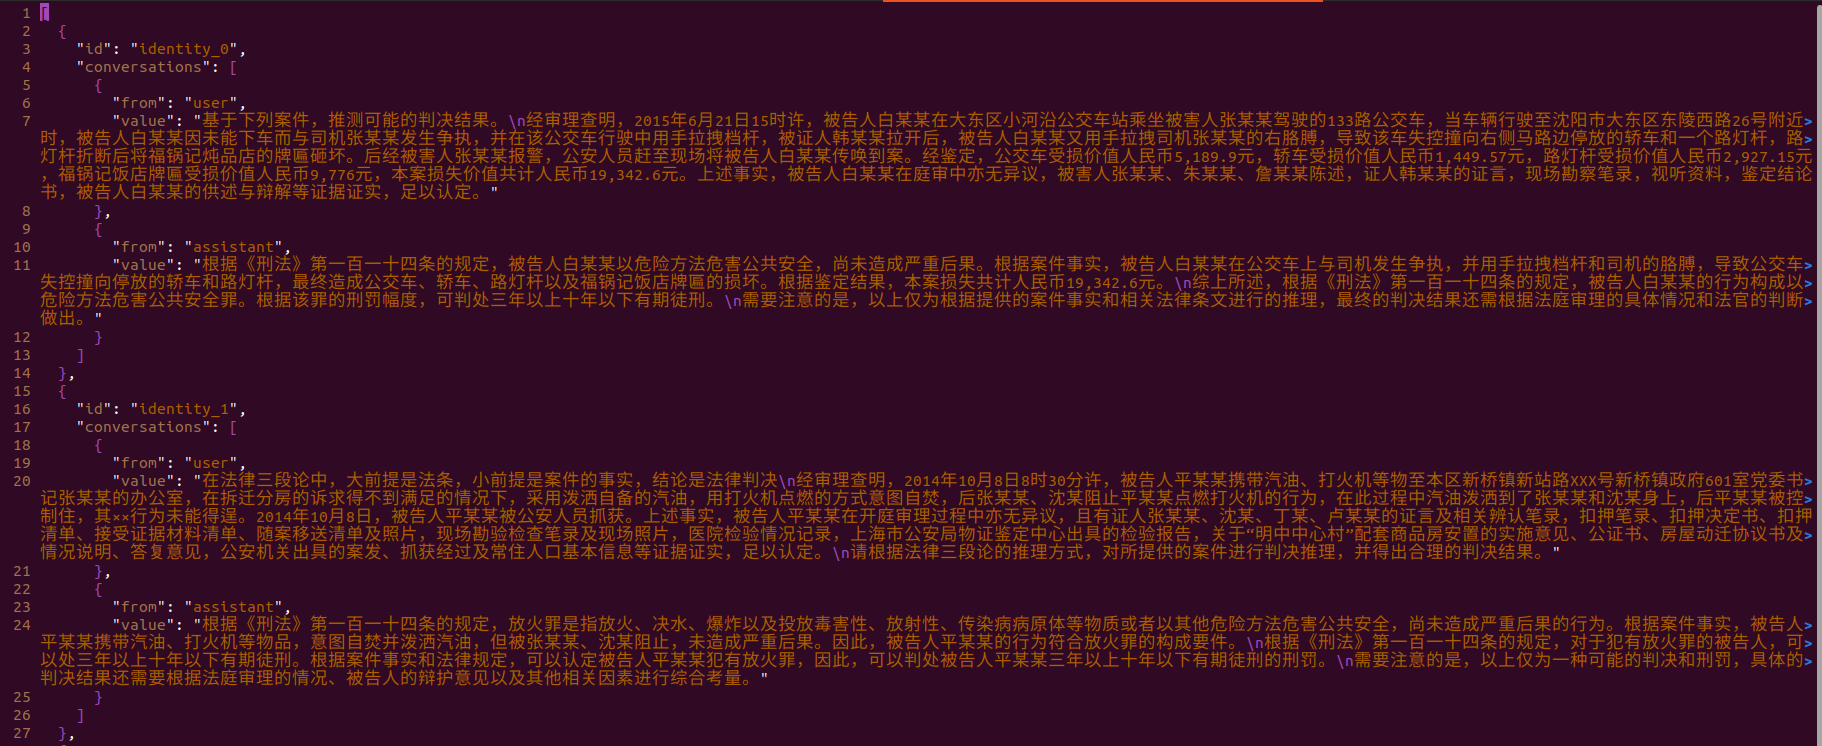

Alpaca格式的train_data_law_alpaca_dataset.json内容如下：

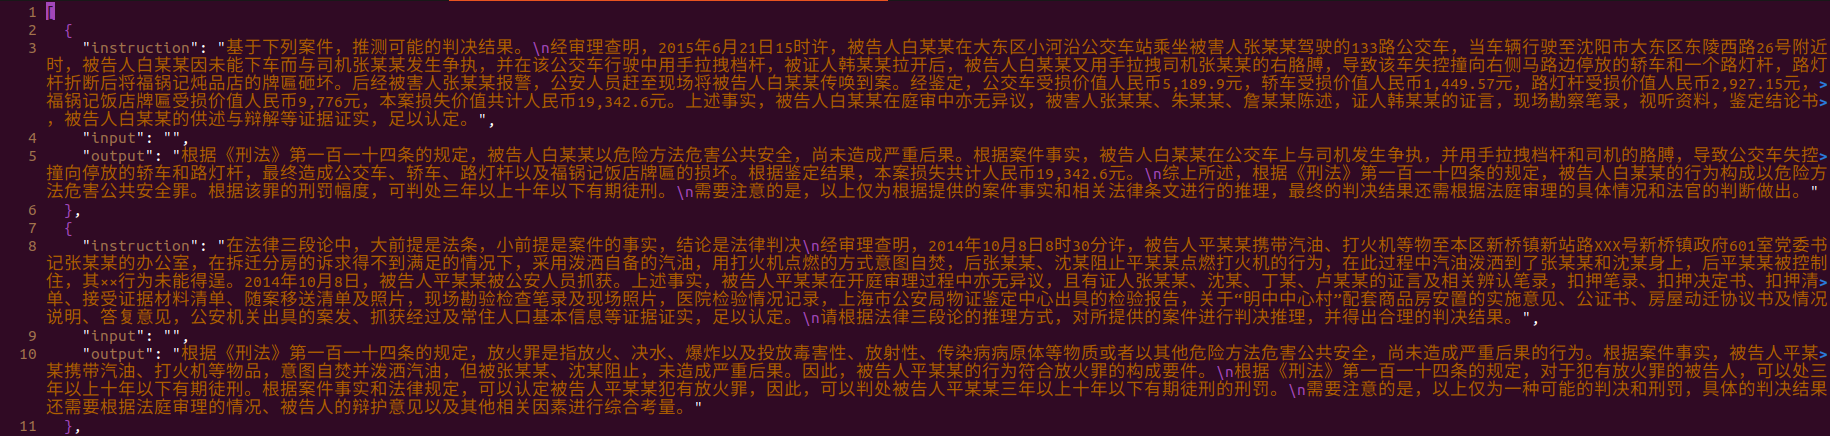

然后将train_data_law_alpaca_dataset.json拷贝到LLaMA-Factory/data目录下，并修改LLaMA-Factory/data/dataset_info.json如下：  

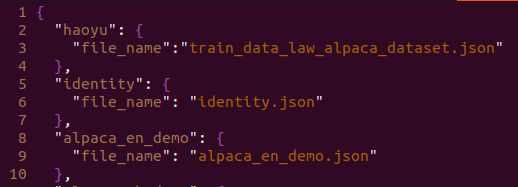

更多关于LLaMA-Factory的自定义数据集规范，参考data/README_zh.md或data/README.md文件。  

cd LLaMA-Factory  
pip install -e .[torch,metrics]  

export USE_MODELSCOPE_HUB=1  
CUDA_VISIBLE_DEVICES=0 GRADIO_SHARE=1 llamafactory-cli webui  

# 主要是选择模型和数据集

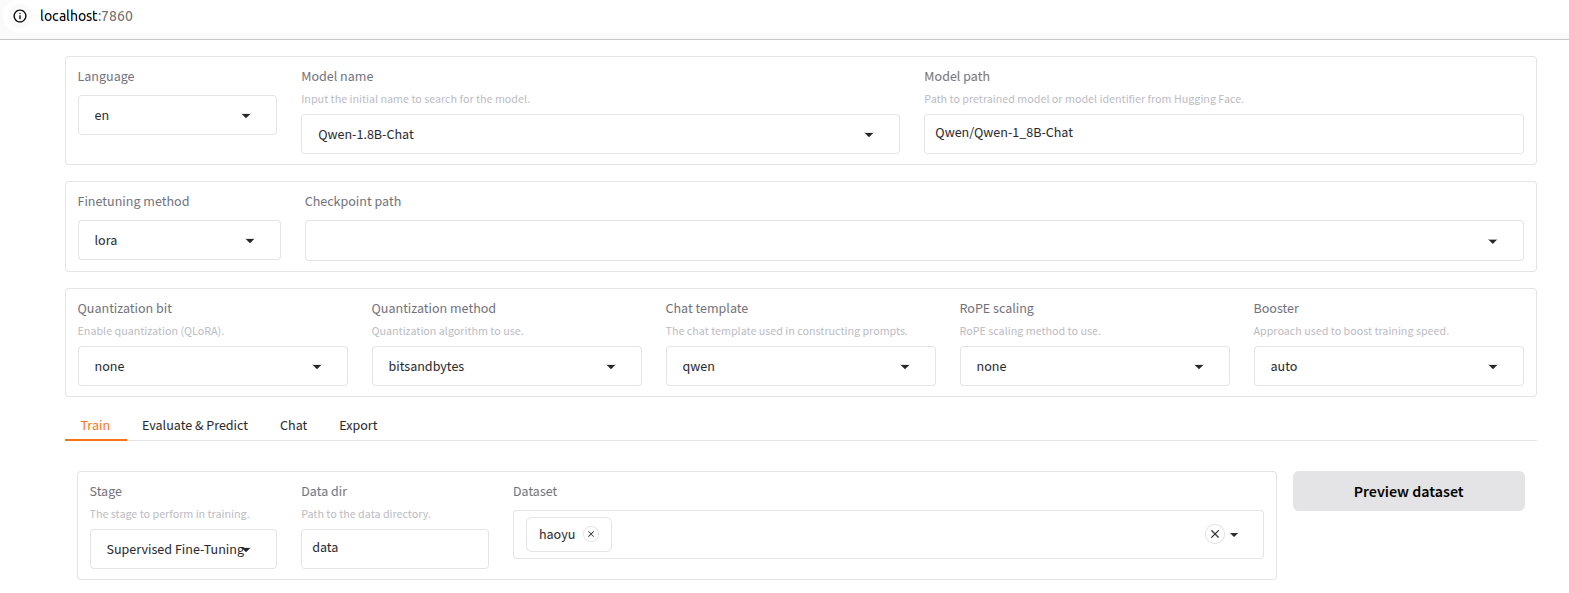

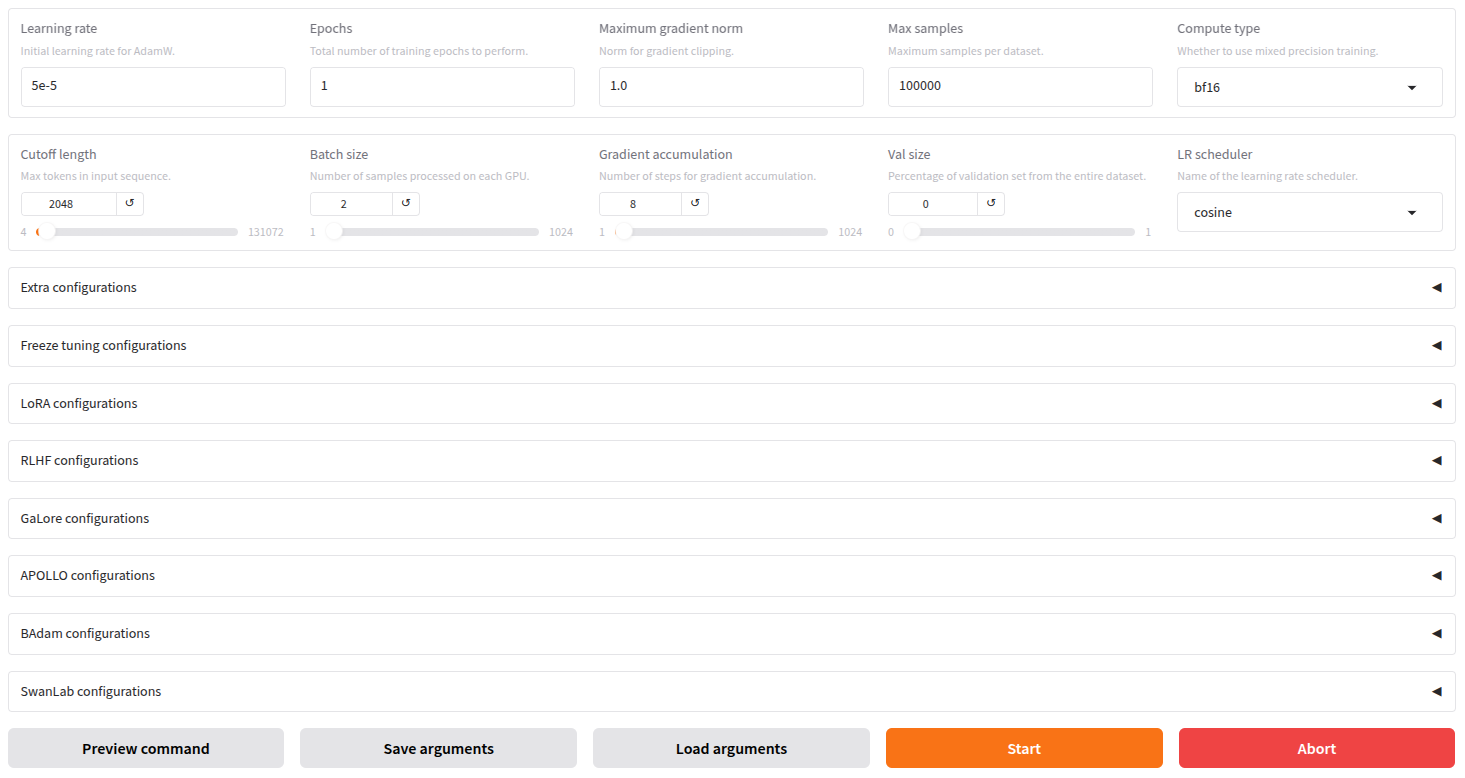

# 点击Start后训练开始

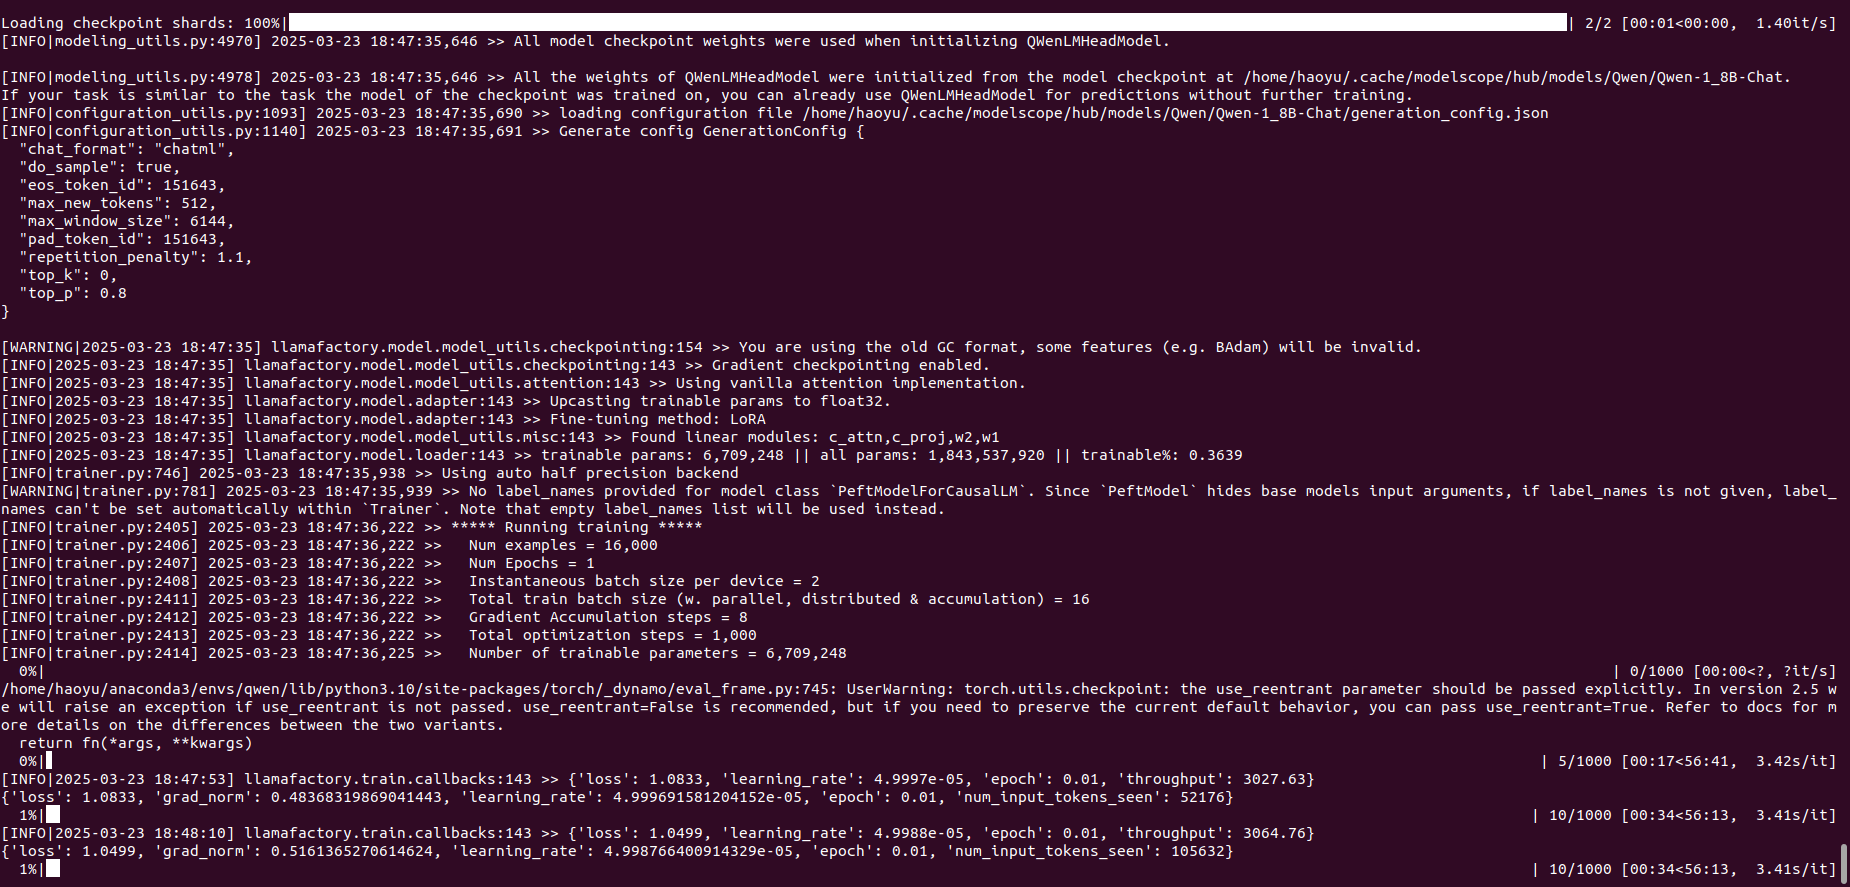

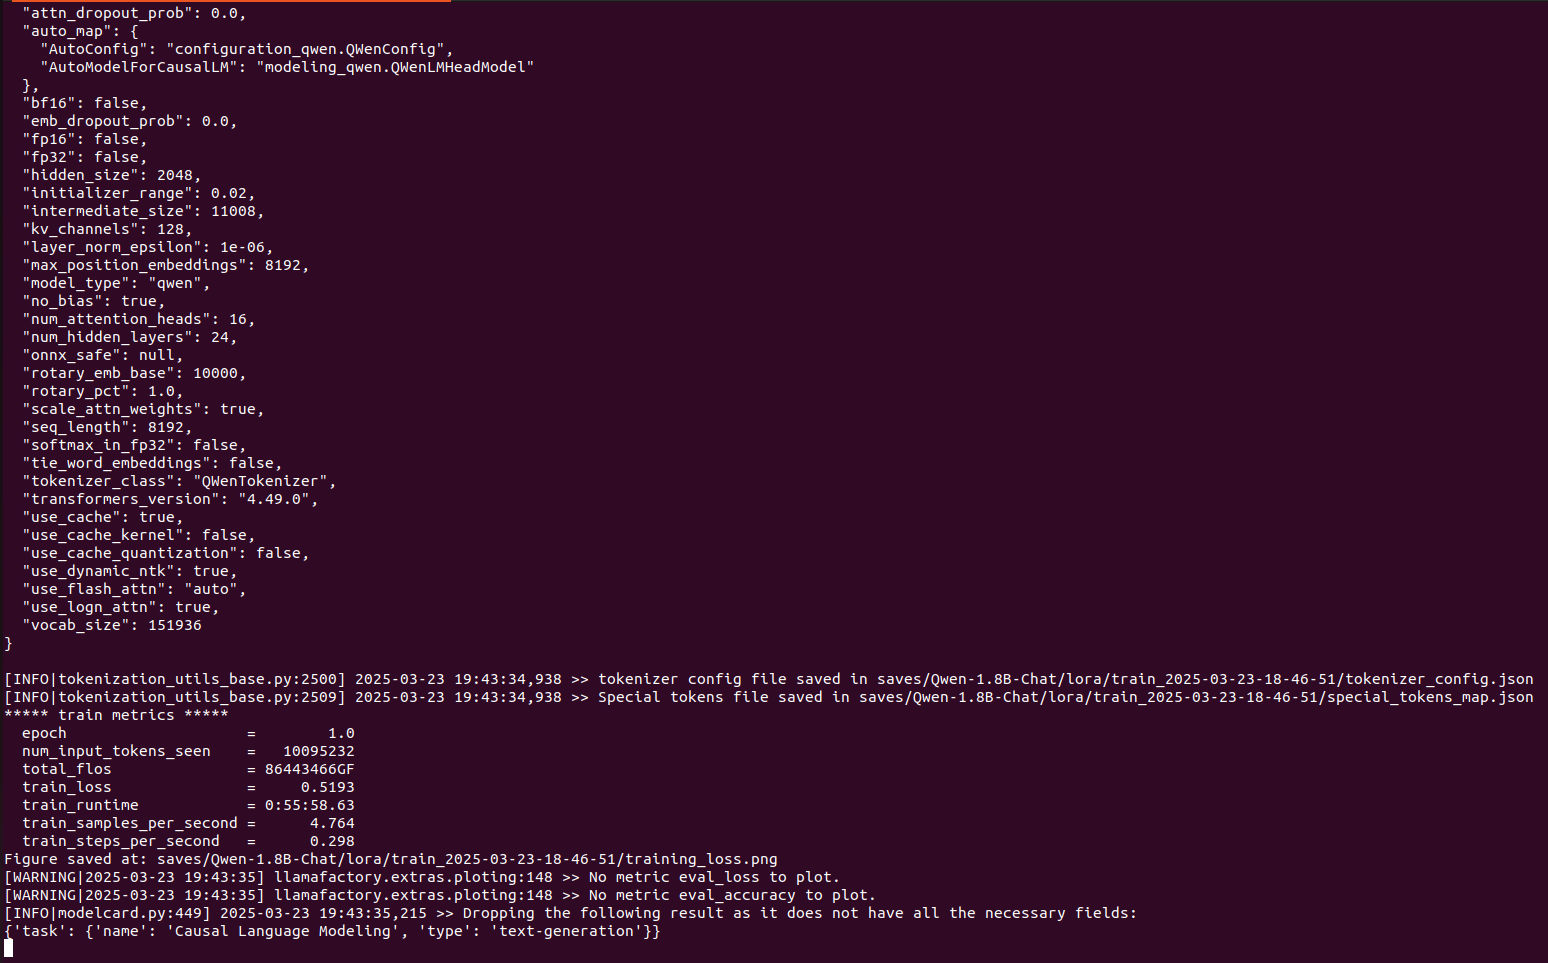

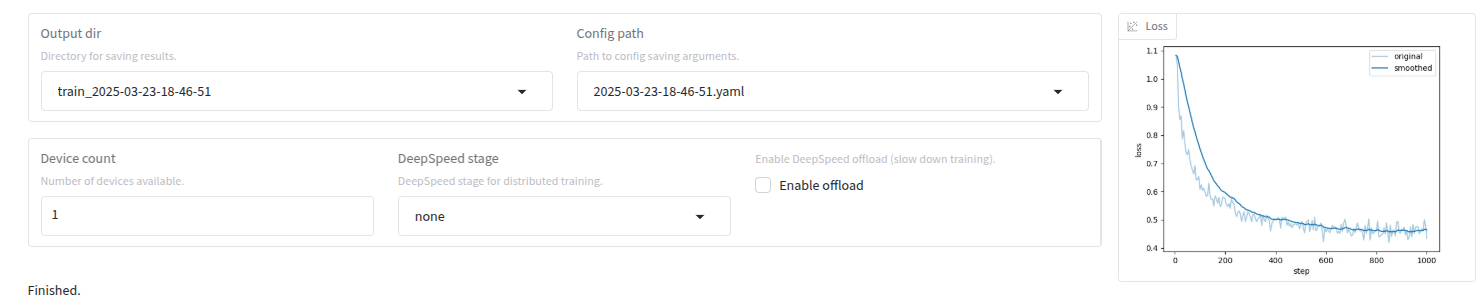

# 导入原始模型

In [2]:
from modelscope import snapshot_download
from transformers import AutoModelForCausalLM, AutoTokenizer
# 因为后面要merge LoRA，所以不能选择量化模型，否则merge LoRA时会出现"Cannot merge LORA layers when the model is gptq quantized"错误
#model_dir = snapshot_download('qwen/Qwen-1_8B-Chat-Int4')
model_dir = snapshot_download('qwen/Qwen-1_8B-Chat')

tokenizer = AutoTokenizer.from_pretrained(model_dir, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    model_dir,
    device_map="auto",
    trust_remote_code=True
).eval()

/home/haoyu/anaconda3/envs/qwen/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2025-03-23 21:29:23,919 - modelscope - WARNING - Model revision not specified, use revision: v1.0.0
The model is automatically converting to bf16 for faster inference. If you want to disable the automatic precision, please manually add bf16/fp16/fp32=True to "AutoModelForCausalLM.from_pretrained".
Try importing flash-attention for faster inference...
Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]


# 提示词模板

In [3]:
prompt_template='''
你是一位专业律师，关于如下案件，请推断可能的判决结果：

“%s”

你的推断是：
'''

# 原始模型回答法律问题效果不佳

In [4]:
model.generation_config.top_p=0 # 只选择概率最高的token

Q_list=["经审理查明，2015年6月21日15时许，被告人白某某在大东区小河沿公交车站乘坐被害人张某某驾驶的133路公交车，当车辆行驶至沈阳市大东区东陵西路26号附近时，被告人白某某因未能下车而与司机张某某发生争执，并在该公交车行驶中用手拉拽档杆，被证人韩某某拉开后，被告人白某某又用手拉拽司机张某某的右胳膊，导致该车失控撞向右侧马路边停放的轿车和一个路灯杆，路灯杆折断后将福锅记炖品店的牌匾砸坏。后经被害人张某某报警，公安人员赶至现场将被告人白某某传唤到案。经鉴定，公交车受损价值人民币5,189.9元，轿车受损价值人民币1,449.57元，路灯杆受损价值人民币2,927.15元，福锅记饭店牌匾受损价值人民币9,776元，本案损失价值共计人民币19,342.6元。上述事实，被告人白某某在庭审中亦无异议，被害人张某某、朱某某、詹某某陈述，证人韩某某的证言，现场勘察笔录，视听资料，鉴定结论书，被告人白某某的供述与辩解等证据证实，足以认定。","经审理查明，2014年10月8日8时30分许，被告人平某某携带汽油、打火机等物至本区新桥镇新站路XXX号新桥镇政府601室党委书记张某某的办公室，在拆迁分房的诉求得不到满足的情况下，采用泼洒自备的汽油，用打火机点燃的方式意图自焚，后张某某、沈某阻止平某某点燃打火机的行为，在此过程中汽油泼洒到了张某某和沈某身上，后平某某被控制住，其××行为未能得逞。2014年10月8日，被告人平某某被公安人员抓获。上述事实，被告人平某某在开庭审理过程中亦无异议，且有证人张某某、沈某、丁某、卢某某的证言及相关辨认笔录，扣押笔录、扣押决定书、扣押清单、接受证据材料清单、随案移送清单及照片，现场勘验检查笔录及现场照片，医院检验情况记录，上海市公安局物证鉴定中心出具的检验报告，关于“明中中心村”配套商品房安置的实施意见、公证书、房屋动迁协议书及情况说明、答复意见，公安机关出具的案发、抓获经过及常住人口基本信息等证据证实，足以认定。"]
for Q in Q_list:
    prompt=prompt_template%(Q,)
    A,hist=model.chat(tokenizer,prompt,history=None)
    print('Q:%s\nA:%s\n'%(Q,A))

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Q:经审理查明，2015年6月21日15时许，被告人白某某在大东区小河沿公交车站乘坐被害人张某某驾驶的133路公交车，当车辆行驶至沈阳市大东区东陵西路26号附近时，被告人白某某因未能下车而与司机张某某发生争执，并在该公交车行驶中用手拉拽档杆，被证人韩某某拉开后，被告人白某某又用手拉拽司机张某某的右胳膊，导致该车失控撞向右侧马路边停放的轿车和一个路灯杆，路灯杆折断后将福锅记炖品店的牌匾砸坏。后经被害人张某某报警，公安人员赶至现场将被告人白某某传唤到案。经鉴定，公交车受损价值人民币5,189.9元，轿车受损价值人民币1,449.57元，路灯杆受损价值人民币2,927.15元，福锅记饭店牌匾受损价值人民币9,776元，本案损失价值共计人民币19,342.6元。上述事实，被告人白某某在庭审中亦无异议，被害人张某某、朱某某、詹某某陈述，证人韩某某的证言，现场勘察笔录，视听资料，鉴定结论书，被告人白某某的供述与辩解等证据证实，足以认定。
A:根据以上案件的事实和证据，可以得出以下可能的判决结果：

1. 被告人白某某的行为构成故意伤害罪，应当判处三年以下有期徒刑或者拘役。
2. 公安机关对被告人的行为进行了处罚，符合法律规定，因此判决应予以维持。
3. 对于被害人的经济损失，法院可以根据实际情况进行调解或者判决赔偿。

需要注意的是，这只是一个初步的推断，具体的判决结果还需要根据具体情况进行判断。

Q:经审理查明，2014年10月8日8时30分许，被告人平某某携带汽油、打火机等物至本区新桥镇新站路XXX号新桥镇政府601室党委书记张某某的办公室，在拆迁分房的诉求得不到满足的情况下，采用泼洒自备的汽油，用打火机点燃的方式意图自焚，后张某某、沈某阻止平某某点燃打火机的行为，在此过程中汽油泼洒到了张某某和沈某身上，后平某某被控制住，其××行为未能得逞。2014年10月8日，被告人平某某被公安人员抓获。上述事实，被告人平某某在开庭审理过程中亦无异议，且有证人张某某、沈某、丁某、卢某某的证言及相关辨认笔录，扣押笔录、扣押决定书、扣押清单、接受证据材料清单、随案移送清单及照片，现场勘验检查笔录及现场照片，医院检验情况记录，上海市公安局物证鉴定中心出具的检验报告，关于“明中中心村”配套商品房安置的实施意见、公证书、房屋动迁协议书及情况说明、答复意见，公安机关出具的案发、抓获经过及常住人口基

# 导入LoRA模型

In [5]:
from peft import AutoPeftModelForCausalLM

model = AutoPeftModelForCausalLM.from_pretrained(
    '/home/haoyu/work/code/DiveIntoFineTuning/LLaMA-Factory/saves/Qwen-1.8B-Chat/lora/train_2025-03-23-18-46-51/checkpoint-1000', # 这个目录是LoRA adapter文件，而不是完整的模型文件，所以用AutoPeftModelForCausalLM
    device_map="auto",
    trust_remote_code=True
).eval()

The model is automatically converting to bf16 for faster inference. If you want to disable the automatic precision, please manually add bf16/fp16/fp32=True to "AutoModelForCausalLM.from_pretrained".
Try importing flash-attention for faster inference...
Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]


# LoRA模型回答法律问题效果有明显提高

In [6]:
model.generation_config.top_p=0 # 只选择概率最高的token

Q_list=["经审理查明，2015年6月21日15时许，被告人白某某在大东区小河沿公交车站乘坐被害人张某某驾驶的133路公交车，当车辆行驶至沈阳市大东区东陵西路26号附近时，被告人白某某因未能下车而与司机张某某发生争执，并在该公交车行驶中用手拉拽档杆，被证人韩某某拉开后，被告人白某某又用手拉拽司机张某某的右胳膊，导致该车失控撞向右侧马路边停放的轿车和一个路灯杆，路灯杆折断后将福锅记炖品店的牌匾砸坏。后经被害人张某某报警，公安人员赶至现场将被告人白某某传唤到案。经鉴定，公交车受损价值人民币5,189.9元，轿车受损价值人民币1,449.57元，路灯杆受损价值人民币2,927.15元，福锅记饭店牌匾受损价值人民币9,776元，本案损失价值共计人民币19,342.6元。上述事实，被告人白某某在庭审中亦无异议，被害人张某某、朱某某、詹某某陈述，证人韩某某的证言，现场勘察笔录，视听资料，鉴定结论书，被告人白某某的供述与辩解等证据证实，足以认定。","经审理查明，2014年10月8日8时30分许，被告人平某某携带汽油、打火机等物至本区新桥镇新站路XXX号新桥镇政府601室党委书记张某某的办公室，在拆迁分房的诉求得不到满足的情况下，采用泼洒自备的汽油，用打火机点燃的方式意图自焚，后张某某、沈某阻止平某某点燃打火机的行为，在此过程中汽油泼洒到了张某某和沈某身上，后平某某被控制住，其××行为未能得逞。2014年10月8日，被告人平某某被公安人员抓获。上述事实，被告人平某某在开庭审理过程中亦无异议，且有证人张某某、沈某、丁某、卢某某的证言及相关辨认笔录，扣押笔录、扣押决定书、扣押清单、接受证据材料清单、随案移送清单及照片，现场勘验检查笔录及现场照片，医院检验情况记录，上海市公安局物证鉴定中心出具的检验报告，关于“明中中心村”配套商品房安置的实施意见、公证书、房屋动迁协议书及情况说明、答复意见，公安机关出具的案发、抓获经过及常住人口基本信息等证据证实，足以认定。"]
for Q in Q_list:
    prompt=prompt_template%(Q,)
    A,hist=model.chat(tokenizer,prompt,history=None)
    print('Q:%s\nA:%s\n'%(Q,A))

Q:经审理查明，2015年6月21日15时许，被告人白某某在大东区小河沿公交车站乘坐被害人张某某驾驶的133路公交车，当车辆行驶至沈阳市大东区东陵西路26号附近时，被告人白某某因未能下车而与司机张某某发生争执，并在该公交车行驶中用手拉拽档杆，被证人韩某某拉开后，被告人白某某又用手拉拽司机张某某的右胳膊，导致该车失控撞向右侧马路边停放的轿车和一个路灯杆，路灯杆折断后将福锅记炖品店的牌匾砸坏。后经被害人张某某报警，公安人员赶至现场将被告人白某某传唤到案。经鉴定，公交车受损价值人民币5,189.9元，轿车受损价值人民币1,449.57元，路灯杆受损价值人民币2,927.15元，福锅记饭店牌匾受损价值人民币9,776元，本案损失价值共计人民币19,342.6元。上述事实，被告人白某某在庭审中亦无异议，被害人张某某、朱某某、詹某某陈述，证人韩某某的证言，现场勘察笔录，视听资料，鉴定结论书，被告人白某某的供述与辩解等证据证实，足以认定。
A:根据《刑法》第二百七十五条的规定，故意毁坏公私财物罪的构成要件包括故意毁坏公私财物并数额较大或者有其他严重情节。根据案件中的事实描述，被告人白某某在公交车行驶过程中使用暴力手段，导致公交车失控撞向路边的物品，造成了一定的经济损失。因此，可以得出以下推理：
 被告人白某某的行为符合故意毁坏财物罪的构成要件；
被告人白某某的行为属于故意毁坏财物罪；
被告人白某某的行为造成了一定的经济损失。
基于以上推理，可以得出以下判断和处罚建议：
被告人白某某犯有故意毁坏财物罪，应当依法判处三年以下有期徒刑、拘役或者罚金的刑罚。具体的刑罚应根据被告人的犯罪情节、社会危害程度以及法律规定进行综合考量。

Q:经审理查明，2014年10月8日8时30分许，被告人平某某携带汽油、打火机等物至本区新桥镇新站路XXX号新桥镇政府601室党委书记张某某的办公室，在拆迁分房的诉求得不到满足的情况下，采用泼洒自备的汽油，用打火机点燃的方式意图自焚，后张某某、沈某阻止平某某点燃打火机的行为，在此过程中汽油泼洒到了张某某和沈某身上，后平某某被控制住，其××行为未能得逞。2014年10月8日，被告人平某某被公安人员抓获。上述事实，被告人平某某在开庭审理过程中亦无异议，且有证人张某某、沈某、丁某、卢某某的证言及相关辨认笔录，扣押笔录、扣押决定书、扣押清单、接受证据材料清单、随案移送

# 合并原始模型和LoRA模型

In [7]:
from peft import AutoPeftModelForCausalLM

path_to_adapter="/home/haoyu/work/code/DiveIntoFineTuning/LLaMA-Factory/saves/Qwen-1.8B-Chat/lora/train_2025-03-23-18-46-51/checkpoint-1000"
new_model_directory="/home/haoyu/work/code/DiveIntoFineTuning/LLaMA-Factory/saves/Qwen-1.8B-Chat/lora/train_2025-03-23-18-46-51/checkpoint-1000_merged"
model = AutoPeftModelForCausalLM.from_pretrained(
   path_to_adapter,
   device_map="auto",
   trust_remote_code=True
).eval()

merged_model = model.merge_and_unload()

# max_shard_size and safe serialization are not necessary.
# They respectively work for sharding checkpoint and save the model to safetensors
merged_model.save_pretrained(new_model_directory, max_shard_size="2048MB", safe_serialization=True)

# 分词器保存
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(
   path_to_adapter,
   trust_remote_code=True
)

tokenizer.save_pretrained(new_model_directory)

The model is automatically converting to bf16 for faster inference. If you want to disable the automatic precision, please manually add bf16/fp16/fp32=True to "AutoModelForCausalLM.from_pretrained".
Try importing flash-attention for faster inference...


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.63it/s]


[2025-03-23 21:30:06,524] [INFO] [real_accelerator.py:222:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/haoyu/anaconda3/envs/qwen/bin/../lib/gcc/x86_64-conda-linux-gnu/11.2.0/../../../../x86_64-conda-linux-gnu/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/home/haoyu/anaconda3/envs/qwen/bin/../lib/gcc/x86_64-conda-linux-gnu/11.2.0/../../../../x86_64-conda-linux-gnu/bin/ld: /usr/local/cuda-12.6/lib64/libcufile.so: undefined reference to `dlvsym'
/home/haoyu/anaconda3/envs/qwen/bin/../lib/gcc/x86_64-conda-linux-gnu/11.2.0/../../../../x86_64-conda-linux-gnu/bin/ld: /usr/local/cuda-12.6/lib64/libcufile.so: undefined reference to `dlopen'
/home/haoyu/anaconda3/envs/qwen/bin/../lib/gcc/x86_64-conda-linux-gnu/11.2.0/../../../../x86_64-conda-linux-gnu/bin/ld: /usr/local/cuda-12.6/lib64/libcufile.so: undefined reference to `dlclose'
/home/haoyu/anaconda3/envs/qwen/bin/../lib/gcc/x86_64-conda-linux-gnu/11.2.0/../../../../x86_64-conda-linux-gnu/bin/ld: /usr/local/cuda-12.6/lib64/libcufile.so: undefined reference to `dlerror'
/home/haoyu/anacon

('/home/haoyu/work/code/DiveIntoFineTuning/LLaMA-Factory/saves/Qwen-1.8B-Chat/lora/train_2025-03-23-18-46-51/checkpoint-1000_merged/tokenizer_config.json',
 '/home/haoyu/work/code/DiveIntoFineTuning/LLaMA-Factory/saves/Qwen-1.8B-Chat/lora/train_2025-03-23-18-46-51/checkpoint-1000_merged/special_tokens_map.json',
 '/home/haoyu/work/code/DiveIntoFineTuning/LLaMA-Factory/saves/Qwen-1.8B-Chat/lora/train_2025-03-23-18-46-51/checkpoint-1000_merged/qwen.tiktoken',
 '/home/haoyu/work/code/DiveIntoFineTuning/LLaMA-Factory/saves/Qwen-1.8B-Chat/lora/train_2025-03-23-18-46-51/checkpoint-1000_merged/added_tokens.json')

# 导入合并模型
做这一步会出错，缺少几个文件，手动从原始模型目录下拷贝到merged目录下可解决。

In [8]:
model_dir = "/home/haoyu/work/code/DiveIntoFineTuning/LLaMA-Factory/saves/Qwen-1.8B-Chat/lora/train_2025-03-23-18-46-51/checkpoint-1000_merged"

tokenizer = AutoTokenizer.from_pretrained(model_dir, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    model_dir,
    device_map="auto",
    trust_remote_code=True
).eval()

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


# 验证合并模型效果有明显提高

In [9]:
model.generation_config.top_p=0 # 只选择概率最高的token

Q_list=["经审理查明，2015年6月21日15时许，被告人白某某在大东区小河沿公交车站乘坐被害人张某某驾驶的133路公交车，当车辆行驶至沈阳市大东区东陵西路26号附近时，被告人白某某因未能下车而与司机张某某发生争执，并在该公交车行驶中用手拉拽档杆，被证人韩某某拉开后，被告人白某某又用手拉拽司机张某某的右胳膊，导致该车失控撞向右侧马路边停放的轿车和一个路灯杆，路灯杆折断后将福锅记炖品店的牌匾砸坏。后经被害人张某某报警，公安人员赶至现场将被告人白某某传唤到案。经鉴定，公交车受损价值人民币5,189.9元，轿车受损价值人民币1,449.57元，路灯杆受损价值人民币2,927.15元，福锅记饭店牌匾受损价值人民币9,776元，本案损失价值共计人民币19,342.6元。上述事实，被告人白某某在庭审中亦无异议，被害人张某某、朱某某、詹某某陈述，证人韩某某的证言，现场勘察笔录，视听资料，鉴定结论书，被告人白某某的供述与辩解等证据证实，足以认定。","经审理查明，2014年10月8日8时30分许，被告人平某某携带汽油、打火机等物至本区新桥镇新站路XXX号新桥镇政府601室党委书记张某某的办公室，在拆迁分房的诉求得不到满足的情况下，采用泼洒自备的汽油，用打火机点燃的方式意图自焚，后张某某、沈某阻止平某某点燃打火机的行为，在此过程中汽油泼洒到了张某某和沈某身上，后平某某被控制住，其××行为未能得逞。2014年10月8日，被告人平某某被公安人员抓获。上述事实，被告人平某某在开庭审理过程中亦无异议，且有证人张某某、沈某、丁某、卢某某的证言及相关辨认笔录，扣押笔录、扣押决定书、扣押清单、接受证据材料清单、随案移送清单及照片，现场勘验检查笔录及现场照片，医院检验情况记录，上海市公安局物证鉴定中心出具的检验报告，关于“明中中心村”配套商品房安置的实施意见、公证书、房屋动迁协议书及情况说明、答复意见，公安机关出具的案发、抓获经过及常住人口基本信息等证据证实，足以认定。"]
for Q in Q_list:
    prompt=prompt_template%(Q,)
    A,hist=model.chat(tokenizer,prompt,history=None)
    print('Q:%s\nA:%s\n'%(Q,A))

Q:经审理查明，2015年6月21日15时许，被告人白某某在大东区小河沿公交车站乘坐被害人张某某驾驶的133路公交车，当车辆行驶至沈阳市大东区东陵西路26号附近时，被告人白某某因未能下车而与司机张某某发生争执，并在该公交车行驶中用手拉拽档杆，被证人韩某某拉开后，被告人白某某又用手拉拽司机张某某的右胳膊，导致该车失控撞向右侧马路边停放的轿车和一个路灯杆，路灯杆折断后将福锅记炖品店的牌匾砸坏。后经被害人张某某报警，公安人员赶至现场将被告人白某某传唤到案。经鉴定，公交车受损价值人民币5,189.9元，轿车受损价值人民币1,449.57元，路灯杆受损价值人民币2,927.15元，福锅记饭店牌匾受损价值人民币9,776元，本案损失价值共计人民币19,342.6元。上述事实，被告人白某某在庭审中亦无异议，被害人张某某、朱某某、詹某某陈述，证人韩某某的证言，现场勘察笔录，视听资料，鉴定结论书，被告人白某某的供述与辩解等证据证实，足以认定。
A:根据《刑法》第二百七十五条的规定，故意毁坏公私财物罪的构成要件包括故意毁坏公私财物并数额较大或者有其他严重情节。根据案件中的事实描述，被告人白某某在公交车行驶过程中使用暴力手段，导致公交车失控撞向路边的物品，造成了一定的经济损失。因此，可以得出以下推理：
 被告人白某某的行为符合故意毁坏财物罪的构成要件；
被告人白某某的行为属于故意毁坏财物罪；
被告人白某某的行为造成了一定的经济损失。
基于以上推理，可以得出以下判断和处罚建议：
被告人白某某犯有故意毁坏财物罪，应当处以三年以下有期徒刑、拘役或者罚金的刑罚。具体的刑罚应根据被告人的犯罪情节、社会危害程度以及法律规定进行综合考量。

Q:经审理查明，2014年10月8日8时30分许，被告人平某某携带汽油、打火机等物至本区新桥镇新站路XXX号新桥镇政府601室党委书记张某某的办公室，在拆迁分房的诉求得不到满足的情况下，采用泼洒自备的汽油，用打火机点燃的方式意图自焚，后张某某、沈某阻止平某某点燃打火机的行为，在此过程中汽油泼洒到了张某某和沈某身上，后平某某被控制住，其××行为未能得逞。2014年10月8日，被告人平某某被公安人员抓获。上述事实，被告人平某某在开庭审理过程中亦无异议，且有证人张某某、沈某、丁某、卢某某的证言及相关辨认笔录，扣押笔录、扣押决定书、扣押清单、接受证据材料清单、随案移送清单